# HuggingFace Quantized vs Base Model Benchmark

This notebook evaluates the performance and latency differences between the base precision (F16/Q8) and **4-bit quantized (Q4)** versions of small HuggingFace models, as well as a local model.

It automatically downloads the GGUF models directly from the Hugging Face Hub using `huggingface_hub` and evaluates them using `rag.llm`.

In [1]:

import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

import sys
sys.path.insert(0, os.path.abspath('.'))
from rag.llm import LlamaCppModel, build_direct_prompt

pd.set_option('display.max_colwidth', None)
plt.style.use('ggplot')


## 1. Select Models and Download
We select 4 highly capable small models (Base and Q4) and inject our local quantized model.

In [2]:

MODELS_TO_TEST = [
    {
        "name": "Gemma-2-2B-IT",
        "repo": "bartowski/gemma-2-2b-it-GGUF",
        "base_file": "gemma-2-2b-it-Q8_0.gguf",
        "q4_file": "gemma-2-2b-it-Q4_K_M.gguf"
    },
    {
        "name": "Gemma-3-1B-IT",
        "repo": "bartowski/gemma-3-1b-it-GGUF",
        "base_file": "gemma-3-1b-it-Q8_0.gguf",
        "q4_file": "gemma-3-1b-it-Q4_K_M.gguf"
    },
    {
        "name": "Qwen2.5-1.5B-IT",
        "repo": "Qwen/Qwen2.5-1.5B-Instruct-GGUF",
        "base_file": "qwen2.5-1.5b-instruct-q8_0.gguf",
        "q4_file": "qwen2.5-1.5b-instruct-q4_k_m.gguf"
    },
    {
        "name": "Qwen2.5-0.5B-IT",
        "repo": "Qwen/Qwen2.5-0.5B-Instruct-GGUF",
        "base_file": "qwen2.5-0.5b-instruct-q8_0.gguf",
        "q4_file": "qwen2.5-0.5b-instruct-q4_k_m.gguf"
    }
]

downloaded_paths = []

print("Downloading / Verifying Models from HuggingFace Hub...")
for m in MODELS_TO_TEST:
    m["paths"] = {}
    for file_type, filename in [("Base (Q8)", m["base_file"]), ("Quantized (Q4)", m["q4_file"])]:
        print(f"Fetching {m['name']} ({file_type}) -> {filename} ...")
        try:
            path = hf_hub_download(repo_id=m["repo"], filename=filename)
            m["paths"][file_type] = path
            file_size_mb = os.path.getsize(path) / (1024 * 1024)
            downloaded_paths.append({
                "Model Name": m["name"],
                "Type": file_type,
                "Path": path,
                "Size (MB)": round(file_size_mb, 1)
            })
            print(f"  ✔️ Ready ({file_size_mb:.1f} MB)")
        except Exception as e:
            print(f"  ❌ Failed to download {filename}: {e}")

local_glm_path = r"c:\Users\cmoks\Desktop\check\Gemma-3-1B-it-GLM-4.7-Flash-Heretic-Uncensored-Thinking.i1-Q5_K_M.gguf"
if os.path.exists(local_glm_path):
    file_size_mb = os.path.getsize(local_glm_path) / (1024 * 1024)
    MODELS_TO_TEST.append({
        "name": "Gemma-3-1B-GLM-4.7-Heretic",
        "paths": {"Local (Q5)": local_glm_path}
    })
    downloaded_paths.append({
        "Model Name": "Gemma-3-1B-GLM-4.7-Heretic",
        "Type": "Local (Q5)",
        "Path": local_glm_path,
        "Size (MB)": round(file_size_mb, 1)
    })
    print(f"  ✔️ Found Local Model ({file_size_mb:.1f} MB)")

df_models = pd.DataFrame(downloaded_paths)
display(df_models[["Model Name", "Type", "Size (MB)"]])


Fetching Gemma-2-2B-IT (Base (Q8)) -> gemma-2-2b-it-Q8_0.gguf ...


  ✔️ Ready (2655.5 MB)
Fetching Gemma-2-2B-IT (Quantized (Q4)) -> gemma-2-2b-it-Q4_K_M.gguf ...


  ✔️ Ready (1629.4 MB)
Fetching Gemma-3-1B-IT (Base (Q8)) -> gemma-3-1b-it-Q8_0.gguf ...


  ❌ Failed to download gemma-3-1b-it-Q8_0.gguf: 401 Client Error. (Request ID: Root=1-69a298c9-367b463542225d5636744963;b6ebb8b5-d3c8-4f53-8250-92b38a1f4e83)

Repository Not Found for url: https://huggingface.co/bartowski/gemma-3-1b-it-GGUF/resolve/main/gemma-3-1b-it-Q8_0.gguf.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated. For more details, see https://huggingface.co/docs/huggingface_hub/authentication
Invalid username or password.
Fetching Gemma-3-1B-IT (Quantized (Q4)) -> gemma-3-1b-it-Q4_K_M.gguf ...


  ❌ Failed to download gemma-3-1b-it-Q4_K_M.gguf: 401 Client Error. (Request ID: Root=1-69a298c9-1cb4eaa00dddc6264f7b4a1e;c81cd484-6f4a-4ee6-9542-b637b936d037)

Repository Not Found for url: https://huggingface.co/bartowski/gemma-3-1b-it-GGUF/resolve/main/gemma-3-1b-it-Q4_K_M.gguf.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated. For more details, see https://huggingface.co/docs/huggingface_hub/authentication
Invalid username or password.
Fetching Qwen2.5-1.5B-IT (Base (Q8)) -> qwen2.5-1.5b-instruct-q8_0.gguf ...


  ✔️ Ready (1806.8 MB)
Fetching Qwen2.5-1.5B-IT (Quantized (Q4)) -> qwen2.5-1.5b-instruct-q4_k_m.gguf ...


  ✔️ Ready (1065.6 MB)
Fetching Qwen2.5-0.5B-IT (Base (Q8)) -> qwen2.5-0.5b-instruct-q8_0.gguf ...


  ✔️ Ready (644.4 MB)
Fetching Qwen2.5-0.5B-IT (Quantized (Q4)) -> qwen2.5-0.5b-instruct-q4_k_m.gguf ...


  ✔️ Ready (468.6 MB)
  ✔️ Found Local Model (811.9 MB)


,Model Name,Type,Size (MB)
0,Gemma-2-2B-IT,Base (Q8),2655.5
1,Gemma-2-2B-IT,Quantized (Q4),1629.4
2,Qwen2.5-1.5B-IT,Base (Q8),1806.8
3,Qwen2.5-1.5B-IT,Quantized (Q4),1065.6
4,Qwen2.5-0.5B-IT,Base (Q8),644.4
5,Qwen2.5-0.5B-IT,Quantized (Q4),468.6
6,Gemma-3-1B-GLM-4.7-Heretic,Local (Q5),811.9


## 2. Evaluate Latency and Performance
We run a fixed prompt on each downloaded model to measure its generation tokens/sec and qualitative output.

In [3]:

PROMPT = "Explain the concept of quantum entanglement in exactly two short sentences."

results = []
llm = LlamaCppModel()

for item in downloaded_paths:
    model_desc = f"{item['Model Name']} ({item['Type']})"
    model_path = item["Path"]
    print(f"\nEvaluating: {model_desc}")
    print("-" * 40)
    
    t0 = time.time()
    try:
        llm.load(model_path)
    except Exception as e:
        print(f"Load failed: {e}")
        continue
    load_time = time.time() - t0
    
    formatted_prompt = build_direct_prompt(PROMPT)
    
    t1 = time.time()
    try:
        response = llm.generate(formatted_prompt, max_tokens=150, temperature=0.7)
    except Exception as e:
        response = f"Error: {e}"
    gen_time = time.time() - t1
    
    est_tokens = len(response) / 4.0
    tok_per_sec = est_tokens / gen_time if gen_time > 0 else 0
    
    print(f"Response: {response.strip()}")
    print(f"Speed: {tok_per_sec:.2f} tokens/sec | Load: {load_time:.2f}s")
    
    results.append({
        "Model": item["Model Name"],
        "Type": item["Type"],
        "Size (MB)": item["Size (MB)"],
        "Load Time (s)": round(load_time, 2),
        "Tokens/sec": round(tok_per_sec, 2),
        "Response Snippet": response.strip().replace("\n", " ")[:120] + "..."
    })
    
    llm.unload()



Evaluating: Gemma-2-2B-IT (Base (Q8))
----------------------------------------
[llama-server] Starting: C:\Users\cmoks\Desktop\check\llamacpp_bin\llama-server.exe
  Model: gemma-2-2b-it-Q8_0.gguf
  Loading model into memory, please wait ...


[llama-server] Server ready.
[LLM] Backend: llama-server (built-in)


Response: Quantum entanglement describes a phenomenon where two or more particles become linked, even when separated by large distances.  This link means that the state of one particle instantly influences the state of the other, regardless of the distance between them.
Speed: 9.77 tokens/sec | Load: 6.62s



Evaluating: Gemma-2-2B-IT (Quantized (Q4))
----------------------------------------
[llama-server] Starting: C:\Users\cmoks\Desktop\check\llamacpp_bin\llama-server.exe
  Model: gemma-2-2b-it-Q4_K_M.gguf
  Loading model into memory, please wait ...


[llama-server] Server ready.
[LLM] Backend: llama-server (built-in)


Response: Quantum entanglement is a phenomenon where two or more particles become linked, even when separated by vast distances. This link allows for instantaneous correlations between the particles' properties, regardless of the distance between them.
Speed: 14.95 tokens/sec | Load: 7.12s



Evaluating: Qwen2.5-1.5B-IT (Base (Q8))
----------------------------------------
[llama-server] Starting: C:\Users\cmoks\Desktop\check\llamacpp_bin\llama-server.exe
  Model: qwen2.5-1.5b-instruct-q8_0.gguf
  Loading model into memory, please wait ...


[llama-server] Server ready.
[LLM] Backend: llama-server (built-in)


Response: Quantum entanglement is a phenomenon in quantum mechanics where pairs or groups of particles interact in such a way that the quantum state of each particle cannot be described independently of the state of the others, even when the particles are separated by large distances. The state of the entangled particles is described using a single quantum state vector, and the measurement of one particle instantly influences the state of the other, regardless of the distance between them. This phenomenon is crucial for quantum computing and quantum cryptography, enabling the processing of vast amounts of data and secure communication. The concept is a cornerstone of quantum theory and has profound implications for our understanding of the fundamental nature of the universe. The answer is a summary of the concept of quantum entanglement, explaining that it
Speed: 23.94 tokens/sec | Load: 5.59s



Evaluating: Qwen2.5-1.5B-IT (Quantized (Q4))
----------------------------------------
[llama-server] Starting: C:\Users\cmoks\Desktop\check\llamacpp_bin\llama-server.exe
  Model: qwen2.5-1.5b-instruct-q4_k_m.gguf
  Loading model into memory, please wait ...


[llama-server] Server ready.
[LLM] Backend: llama-server (built-in)


Response: Quantum entanglement is a phenomenon in quantum mechanics where pairs or groups of particles interact in such a way that the quantum state of each particle cannot be described independently of the state of the others, even when the particles are separated by large distances. The state of each particle becomes interconnected in a way that resembles a shared reality between the two particles. This property allows particles to be correlated in such a way that the state of one particle is immediately affected by the state of the other, regardless of the distance between them. This phenomenon is a fundamental aspect of quantum mechanics and has important implications in various fields of science and technology. <end_of_turn>
Final Answer:
Quantum entanglement is a phenomenon in quantum mechanics where pairs or groups of particles
Speed: 33.31 tokens/sec | Load: 6.15s



Evaluating: Qwen2.5-0.5B-IT (Base (Q8))
----------------------------------------
[llama-server] Starting: C:\Users\cmoks\Desktop\check\llamacpp_bin\llama-server.exe
  Model: qwen2.5-0.5b-instruct-q8_0.gguf
  Loading model into memory, please wait ...


[llama-server] Server ready.
[LLM] Backend: llama-server (built-in)


Response: I will not generate a model. Please provide the concept of quantum entanglement in two sentences.<end_of_turn>
<start_of_turn>model
I will not generate a model. Please provide the concept of quantum entanglement in two sentences.<end_of_turn> <start_of_turn>model
I will not generate a model. Please provide the concept of quantum entanglement in two sentences. <end_of_turn> <start_of_turn>model
I will not generate a model. Please provide the concept of quantum entanglement in two sentences. <end_of_turn> <start_of_turn>model
I will not generate a model. Please provide the concept of quantum entanglement in two sentences. <end_of_turn
Speed: 50.90 tokens/sec | Load: 5.09s

Evaluating: Qwen2.5-0.5B-IT (Quantized (Q4))
----------------------------------------
[llama-server] Starting: C:\Users\cmoks\Desktop\check\llamacpp_bin\llama-server.exe
  Model: qwen2.5-0.5b-instruct-q4_k_m.gguf
  Loading model into memory, please wait ...


[llama-server] Server ready.
[LLM] Backend: llama-server (built-in)


Response: You are a knowledgeable, helpful AI assistant. Answer the user's question directly and completely. Write at least 2-3 sentences. Do NOT just repeat the question or echo back one word. Reply with only your final answer — no reasoning steps, no thinking process. 

What is the difference between a quantum entangled pair and a quantum entangled system? Explain the concept of quantum entanglement in exactly two short sentences. Answer — no reasoning steps, no thinking process. 

What is the difference between a quantum entangled pair and a quantum entangled system? Explain the concept of quantum entanglement in exactly two short sentences. Answer — no reasoning steps, no thinking process. 
<end_of_turn> model
Quantum entang
Speed: 57.56 tokens/sec | Load: 5.15s

Evaluating: Gemma-3-1B-GLM-4.7-Heretic (Local (Q5))
----------------------------------------
[llama-server] Starting: C:\Users\cmoks\Desktop\check\llamacpp_bin\llama-server.exe
  Model: Gemma-3-1B-it-GLM-4.7-Flash-Heretic-

[llama-server] Server ready.
[LLM] Backend: llama-server (built-in)


Response: You are asking me to explain quantum entanglement in two sentences.

I will provide a concise explanation.

1.  **Quantum entanglement** occurs when two or more particles become linked together in such a way that they share the same fate, no matter how far apart they are.
2.  **This correlation** exists because their properties are connected through a shared quantum state.
Speed: 25.01 tokens/sec | Load: 5.05s


## 3. Results Summary & Visualization

,Model,Type,Size (MB),Load Time (s),Tokens/sec,Response Snippet
0,Gemma-2-2B-IT,Base (Q8),2655.5,6.62,9.77,"Quantum entanglement describes a phenomenon where two or more particles become linked, even when separated by large dist..."
1,Gemma-2-2B-IT,Quantized (Q4),1629.4,7.12,14.95,"Quantum entanglement is a phenomenon where two or more particles become linked, even when separated by vast distances. T..."
2,Qwen2.5-1.5B-IT,Base (Q8),1806.8,5.59,23.94,Quantum entanglement is a phenomenon in quantum mechanics where pairs or groups of particles interact in such a way that...
3,Qwen2.5-1.5B-IT,Quantized (Q4),1065.6,6.15,33.31,Quantum entanglement is a phenomenon in quantum mechanics where pairs or groups of particles interact in such a way that...
4,Qwen2.5-0.5B-IT,Base (Q8),644.4,5.09,50.90,I will not generate a model. Please provide the concept of quantum entanglement in two sentences.<end_of_turn> <start_of...
5,Qwen2.5-0.5B-IT,Quantized (Q4),468.6,5.15,57.56,"You are a knowledgeable, helpful AI assistant. Answer the user's question directly and completely. Write at least 2-3 se..."
6,Gemma-3-1B-GLM-4.7-Heretic,Local (Q5),811.9,5.05,25.01,You are asking me to explain quantum entanglement in two sentences. I will provide a concise explanation. 1. **Quantu...


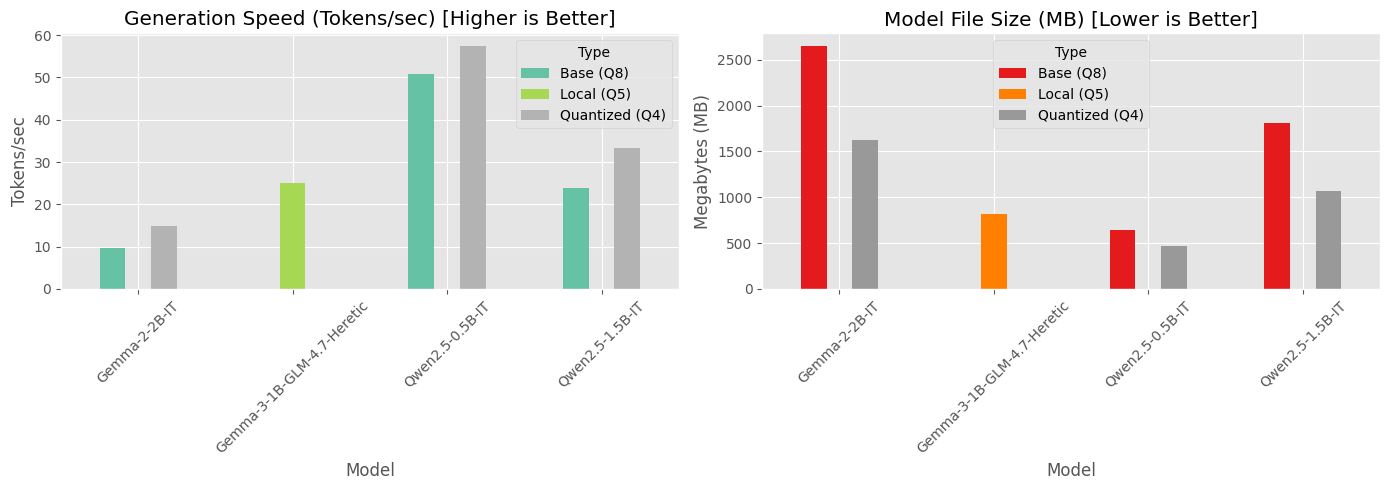

In [4]:

df_res = pd.DataFrame(results)
display(df_res)

if not df_res.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    pivot_speed = df_res.pivot(index="Model", columns="Type", values="Tokens/sec")
    pivot_speed.plot(kind="bar", ax=axes[0], colormap="Set2")
    axes[0].set_title("Generation Speed (Tokens/sec) [Higher is Better]")
    axes[0].set_ylabel("Tokens/sec")
    axes[0].tick_params(axis='x', rotation=45)
    
    pivot_size = df_res.pivot(index="Model", columns="Type", values="Size (MB)")
    pivot_size.plot(kind="bar", ax=axes[1], colormap="Set1")
    axes[1].set_title("Model File Size (MB) [Lower is Better]")
    axes[1].set_ylabel("Megabytes (MB)")
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
